In [41]:
import os

import numpy as np
import seaborn as sns
import pandas as pd
import pickle as pkl

from pathlib import Path
from tqdm import tqdm
from loguru import logger
import matplotlib.pyplot as plt
import warnings

plt.rcParams["figure.figsize"] = (16, 9)


In [42]:
warnings.simplefilter('ignore')

In [2]:
os.chdir('..')

In [3]:
from engine.model import SimpleMlp, LeNet
from engine.trainer import TrainingResults 

## Preprocessing

In [4]:
results_path = Path('results')

lenet_path = results_path / 'lenet_theoretical'
mlp_path = results_path / 'mlp_theoretical'

In [9]:
def results_to_df(res: TrainingResults) -> pd.DataFrame:
    subdfs = []

    for idx, res_items in enumerate(zip(res.optimal_lrs, res.scheduler_lrs, res.losses)):
        subdf = pd.DataFrame()
        lrs = res_items[0]
        for key, item in lrs.items():
            elements = key.split('.')
            layer_num, layer_item = elements[1], elements[2]
            row = pd.DataFrame(data={
                'iter': [idx],
                'layer': [layer_num],
                'layer_el': [layer_item],
                'lr_optim': [float(item)],
            })
            subdf = pd.concat([subdf, row])
        
        subdfs.append(subdf)
    
            
    return pd.concat(subdfs)

def scheduler_to_df(res: TrainingResults) -> pd.DataFrame:
    df = pd.DataFrame(data={'scheduler_lr': res.scheduler_lrs})
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'iter'}, inplace=True)
    return df

def losses_to_df(res: TrainingResults) -> pd.DataFrame:
    df = pd.DataFrame(data={'loss': res.losses})
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'iter'}, inplace=True)
    return df

In [54]:
output_path = Path('results/theoretical_results_merged.csv')
if not output_path.is_file():
    dirs = {
        'lenet': {
            'constant': lenet_path / 'Constant',
            'scheduler': lenet_path / 'OneCycle'
        },
        'mlp': {
            'constant': mlp_path / 'Constant',
            'scheduler': mlp_path / 'OneCycle'
        }
    }

    for model_name, training_types in dirs.items():
        for training_name, results_dir in training_types.items():
            print(results_dir)
            logger.info(f'Start {model_name}-{training_name}')
            files = results_dir.glob('results*')
        
            for filename in tqdm(files):
                with open(filename, 'rb') as f:
                    res = pkl.load(f)
                    
                losses = losses_to_df(res)
                scheduler_lr = scheduler_to_df(res)
                
                df = results_to_df(res)
                df['filename'] = filename.stem
                df['model'] = model_name
                df['training_type'] = training_name
                
                df = df.merge(losses, on='iter')
                df = df.merge(scheduler_lr, on='iter')
                
                df.to_csv(f'results-{filename.stem}-{model_name}-{training_name}.csv', index=False)
    
    
    dfs = []
    result_paths = Path('.').glob('*.csv')
    for result_path in result_paths:
        df = pd.read_csv(result_path)
        dfs.append(df)
        
    df_all = pd.concat(dfs)

    df_all.to_csv(output_path, index=False)
else:
    df_all = pd.read_csv(output_path)

2024-05-19 17:47:28.447 | INFO     | __main__:<module>:17 - Start lenet-constant


results/lenet_theoretical/Constant


10it [06:16, 37.69s/it]


## Viz utils

In [19]:
df_all.head()

,iter,layer,layer_el,lr_optim,filename,model,training_type,loss,scheduler_lr
0,0,0,weight,6.244739e-06,results_0,lenet,scheduler,2.303401,0.00004
1,0,0,bias,4.191040e-08,results_0,lenet,scheduler,2.303401,0.00004
2,0,3,weight,1.275617e-04,results_0,lenet,scheduler,2.303401,0.00004
3,0,3,bias,2.106950e-06,results_0,lenet,scheduler,2.303401,0.00004
4,0,7,weight,1.445709e-04,results_0,lenet,scheduler,2.303401,0.00004


In [71]:
def get_plot_per_layer_ratio(df: pd.DataFrame, model: str, n_cols: int = 3):
    df = df[df['model'] == model]
    
    layers_ids = df['layer'].unique()
    n_rows = int(np.ceil(len(layers_ids) / n_cols))
    
    _, axes = plt.subplots(n_rows, n_cols)
    
    for idx, layer_id in enumerate(layers_ids):
        df_temp = df[df['layer'] == layer_id]
        df_temp.loc[:,'lr_ratio'] = df_temp['lr_optim'] / df_temp['scheduler_lr']
        df_temp['const'] = 1
        sns.lineplot(df_temp, x='iter', y='lr_ratio', hue='layer_el', ax=axes[idx // n_cols, idx % n_cols],).set(title=f'Layer={layer_id}', yscale='log')
        sns.lineplot(df_temp, x='iter', y='const', ax=axes[idx // n_cols, idx % n_cols], color="r").set()
        
    plt.suptitle('Ratio of the optimal and actually used learning rate (logscale)')
    
def get_plot_per_layer(df: pd.DataFrame, model: str, n_cols: int = 3):
    df = df[df['model'] == model]
    
    layers_ids = df['layer'].unique()
    n_rows = int(np.ceil(len(layers_ids) / n_cols))
    
    _, axes = plt.subplots(n_rows, n_cols)
    
    for idx, layer_id in enumerate(layers_ids):
        df_temp = df[df['layer'] == layer_id]
        sns.lineplot(df_temp, x='iter', y='lr_optim', hue='layer_el', ax=axes[idx // n_cols, idx % n_cols],).set(title=f'Layer={layer_id}')
        sns.lineplot(df_temp, x='iter', y='scheduler_lr', ax=axes[idx // n_cols, idx % n_cols], color="r").set()
        
    plt.suptitle('Comparing optimal and actually used learning rate')

    

## LeNet Analysis

### Constant

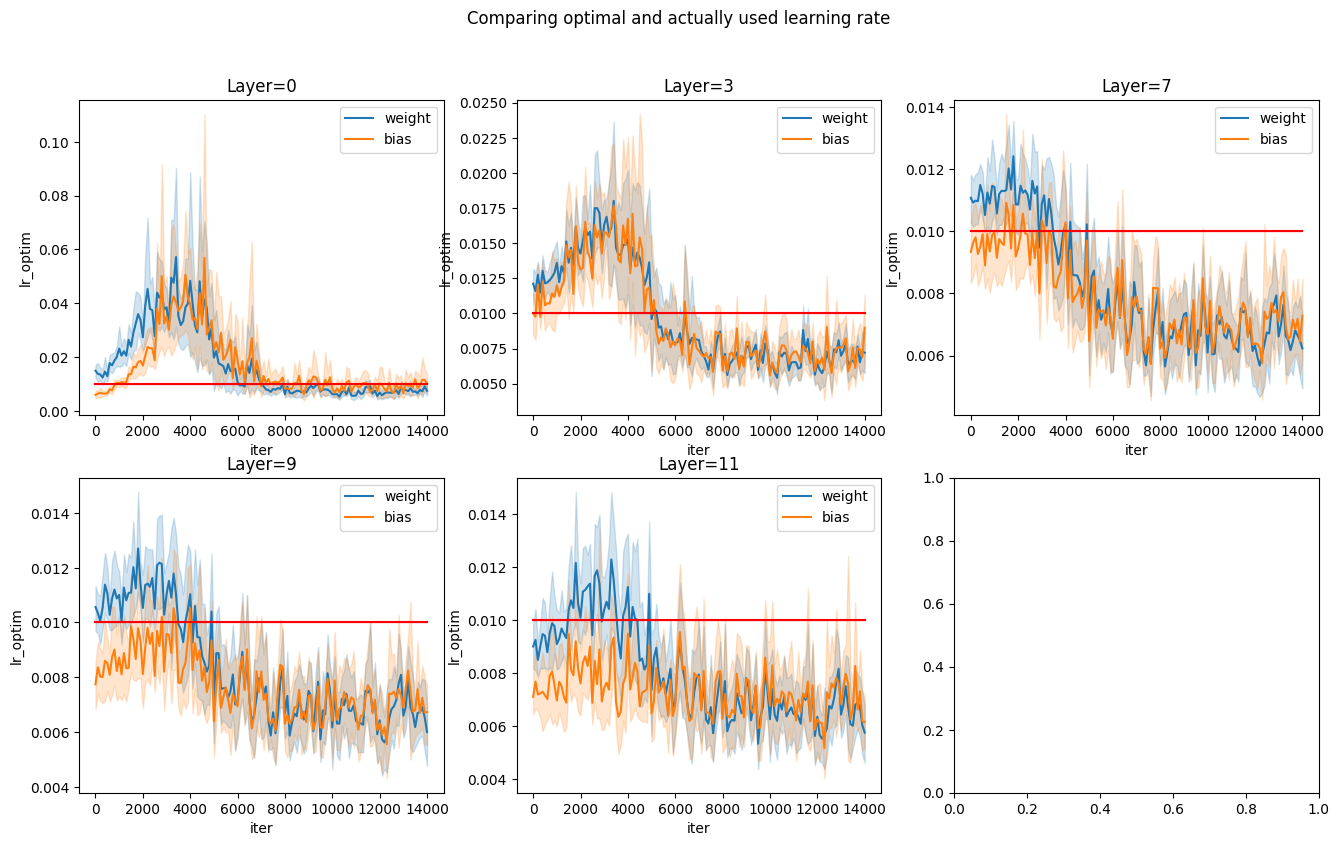

In [70]:
tmp = df_all[df_all['training_type'] == 'constant']
tmp = tmp[tmp['iter'] % 100 == 0]

g = get_plot_per_layer(tmp, 'lenet')
g

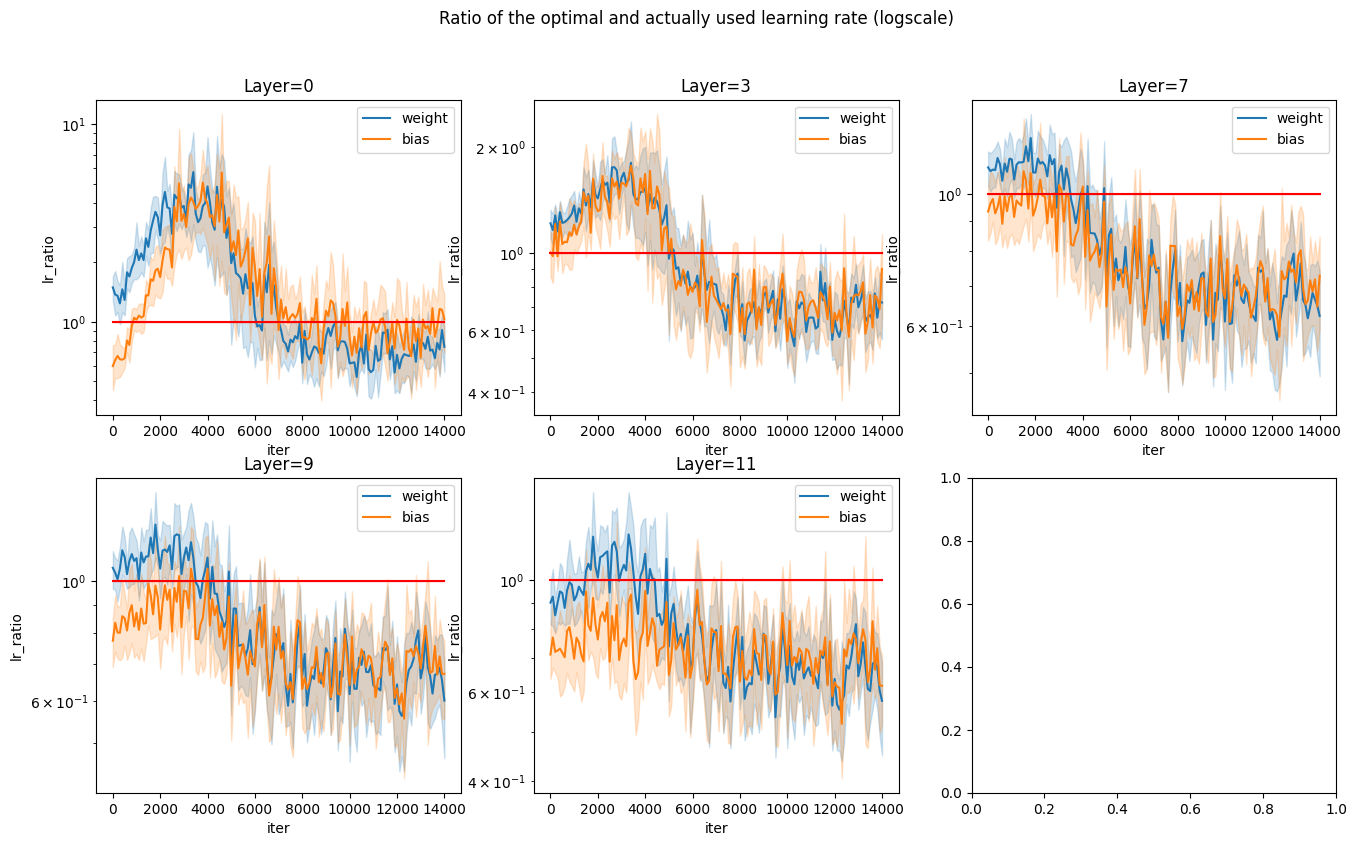

In [72]:
tmp = df_all[df_all['training_type'] == 'constant']
tmp = tmp[tmp['iter'] % 100 == 0]

g = get_plot_per_layer_ratio(tmp, 'lenet')
g

### Scheduler

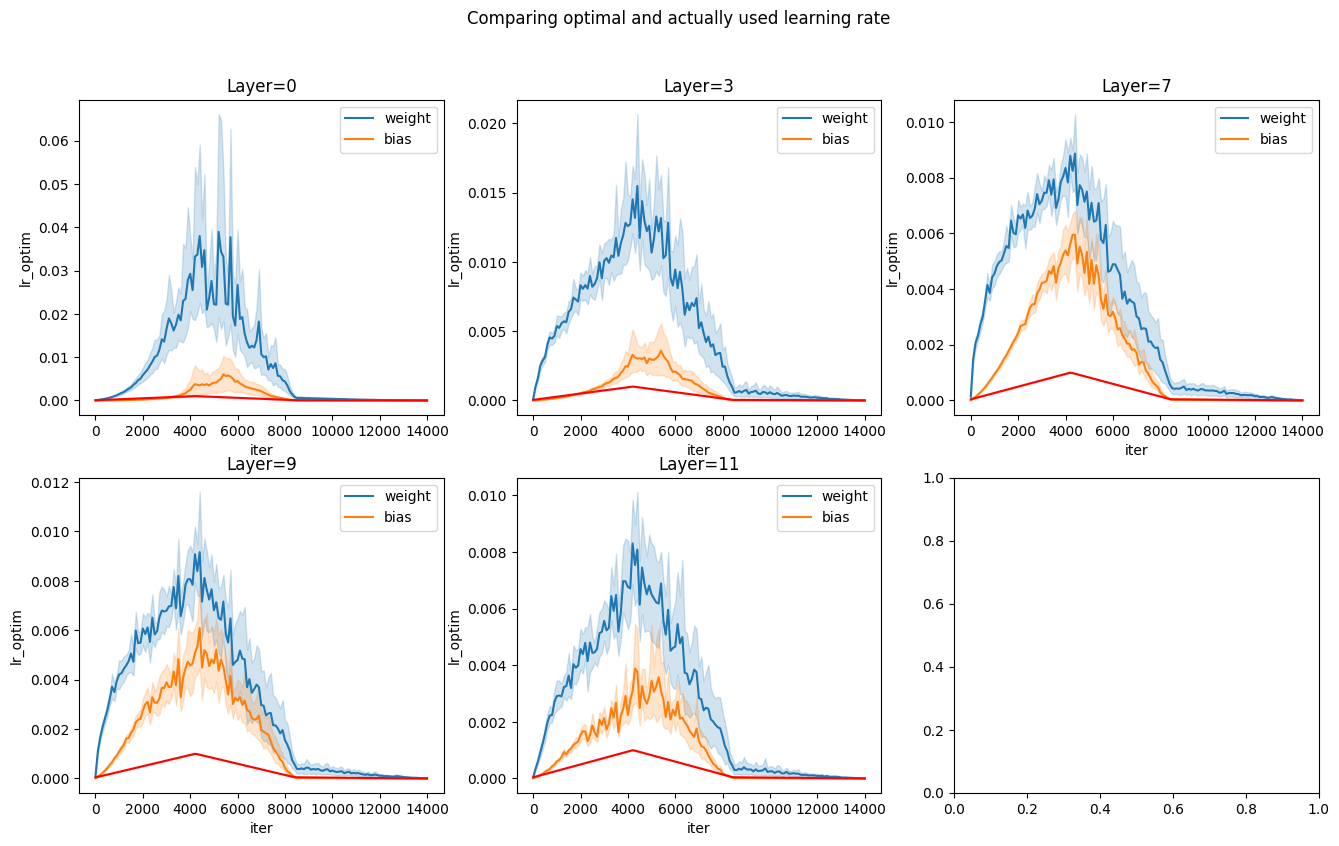

In [73]:
tmp = df_all[df_all['training_type'] == 'scheduler']
tmp = tmp[tmp['iter'] % 100 == 0]

g = get_plot_per_layer(tmp, 'lenet')
g

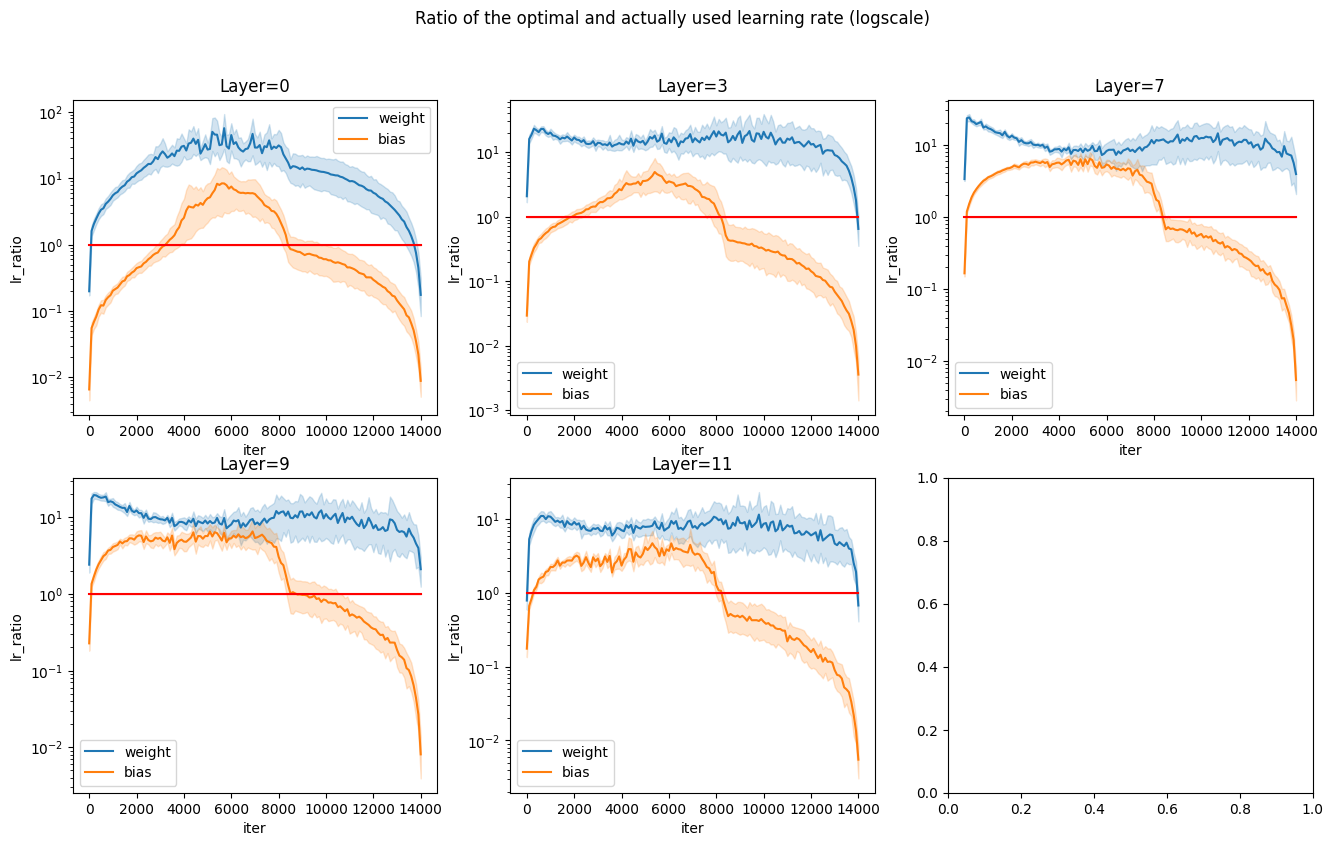

In [74]:
tmp = df_all[df_all['training_type'] == 'scheduler']
tmp = tmp[tmp['iter'] % 100 == 0]

g = get_plot_per_layer_ratio(tmp, 'lenet')
g

## MLP analysis

### Constant

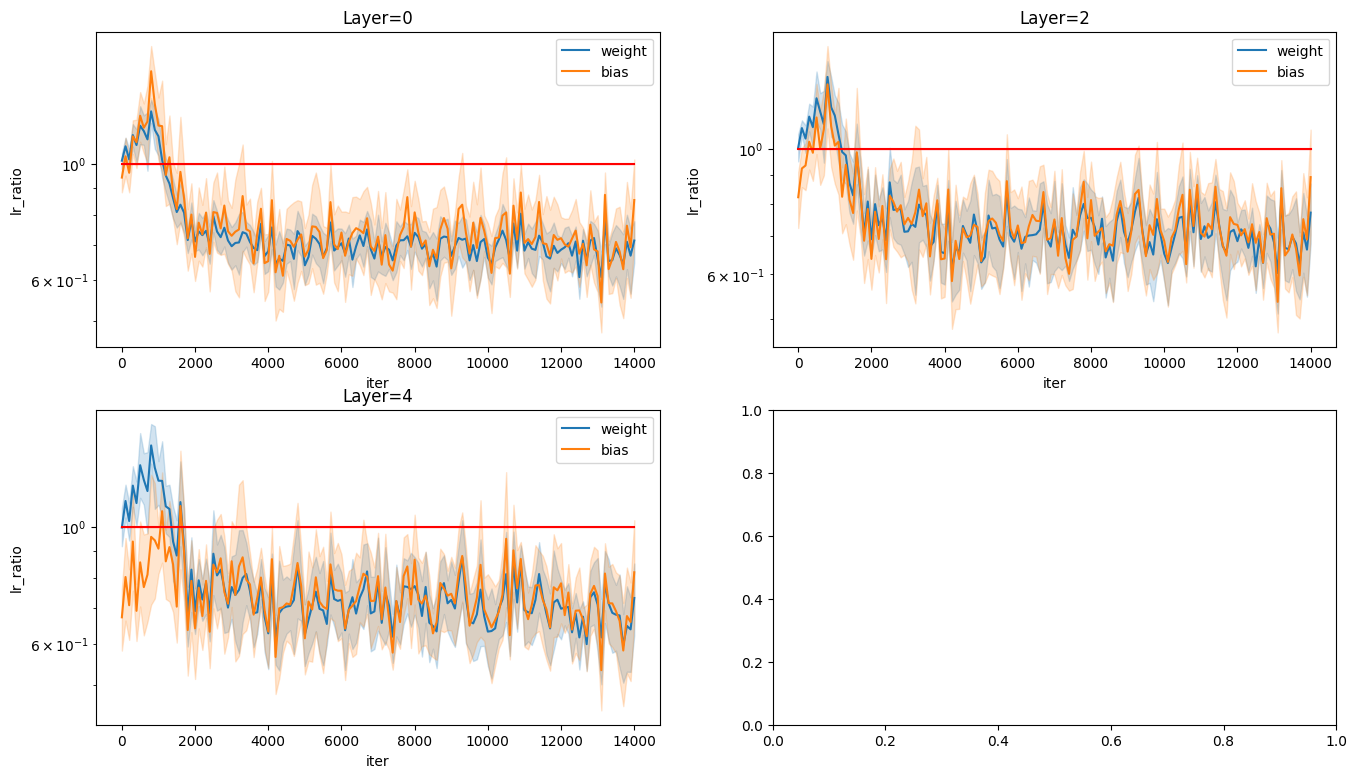

In [51]:
tmp = df_all[df_all['training_type'] == 'constant']
tmp = tmp[tmp['iter'] % 100 == 0]

g = get_plot_per_layer(tmp, 'mlp', n_cols=2)
g

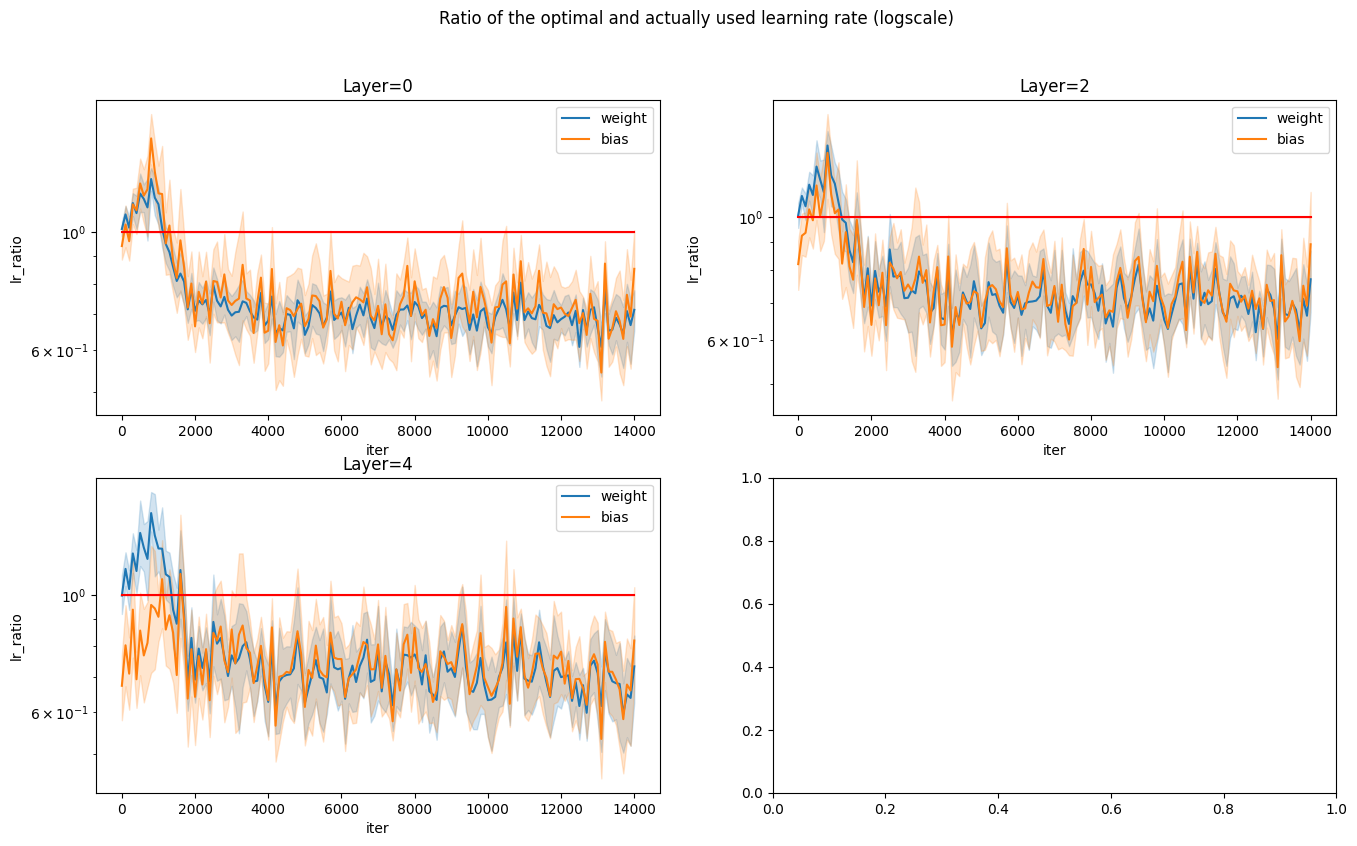

In [75]:
tmp = df_all[df_all['training_type'] == 'constant']
tmp = tmp[tmp['iter'] % 100 == 0]

g = get_plot_per_layer_ratio(tmp, 'mlp', n_cols=2)
g

### Scheduler

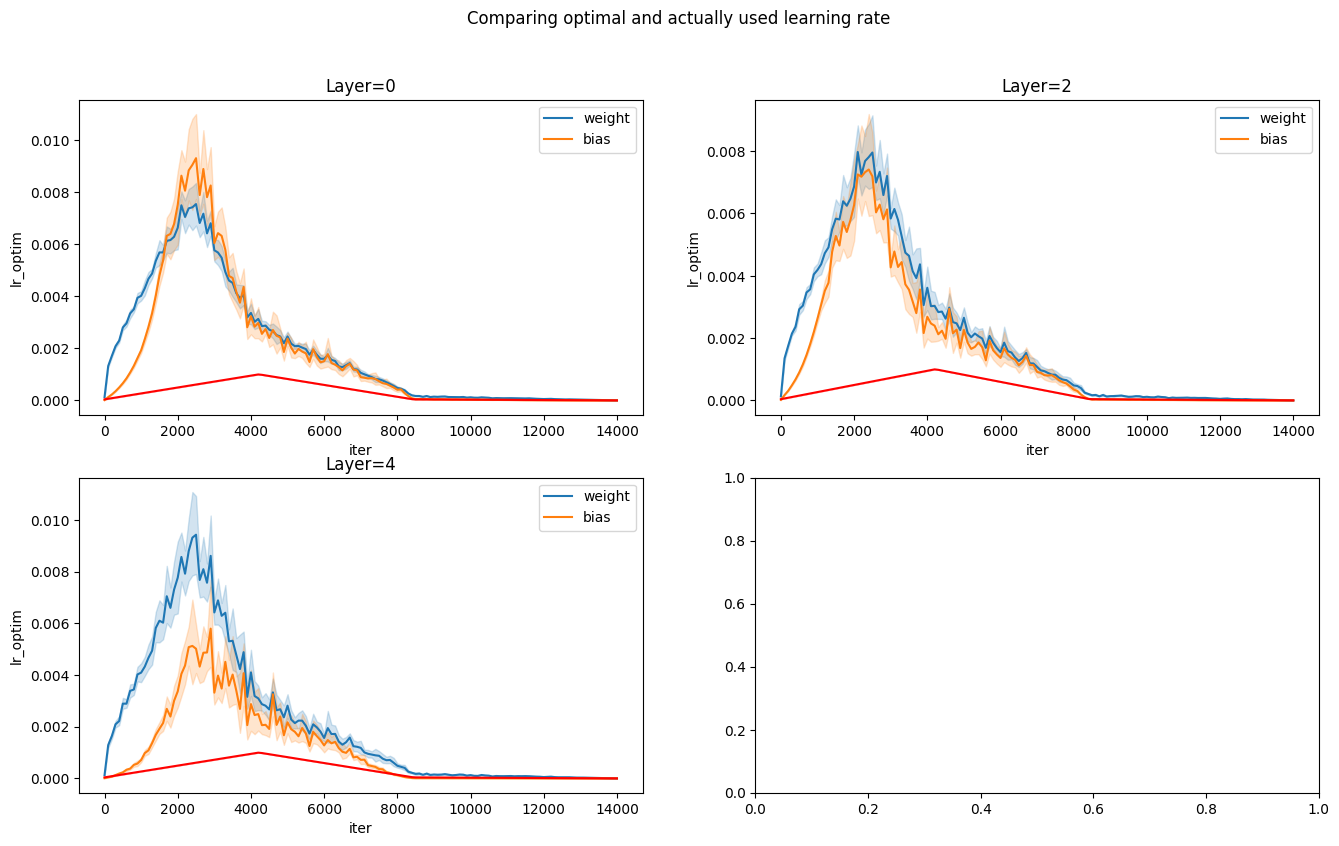

In [76]:
tmp = df_all[df_all['training_type'] == 'scheduler']
tmp = tmp[tmp['iter'] % 100 == 0]

g = get_plot_per_layer(tmp, 'mlp', n_cols=2)
g

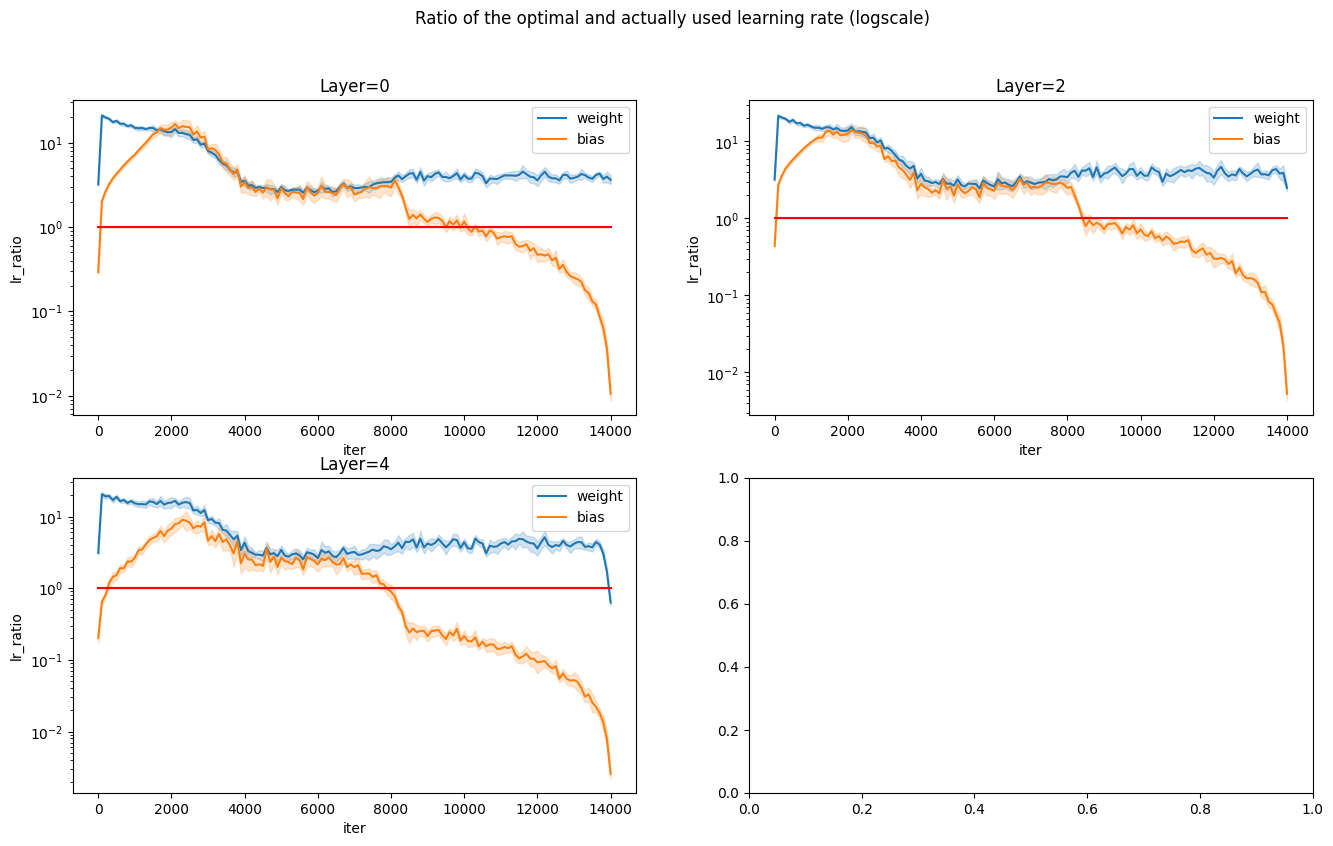

In [77]:
tmp = df_all[df_all['training_type'] == 'scheduler']
tmp = tmp[tmp['iter'] % 100 == 0]

g = get_plot_per_layer_ratio(tmp, 'mlp', n_cols=2)
g